# Simple CNN ( Kent Chiu )
### Introduction


In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import os, sys, progressbar, argparse 
import commentjson as json

from imutils import paths
from skimage.io import imread
import imageio
import cv2

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json

Using Theano backend.
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64/tmp5apf9q/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64/tmp5apf9q/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN 5103)
C:\Users\kentc\Anaconda2\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Define CNN Architectures

In [2]:

def simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, Dense_Before_Out=32):
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(Dense_Before_Out, init='lecun_uniform'))
    model.add(Activation('tanh'))
    
    model.add(Dense(nb_classes, init='lecun_uniform'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    return model

def simpleCNN_2(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, Dense_Before_Out=32):
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
    model.add(Activation('tanh'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(10*Dense_Before_Out, init='lecun_uniform'))
    model.add(Activation('tanh'))    
    
    model.add(Dense(Dense_Before_Out, init='lecun_uniform'))
    model.add(Activation('tanh'))
    
    model.add(Dense(nb_classes, init='lecun_uniform'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    return model

# Clean the dataset 
## ImageFolder_Name



In [3]:

class Conf:
    def __init__(self, confPath):
        # load and store the configuration and update the object's dictionary
        conf = json.loads(open(confPath).read())
        self.__dict__.update(conf)

    def __getitem__(self, k):
        # return the value associated with the supplied key
        return self.__dict__.get(k, None)
    
    
def auto_resized(img,size):
    '''size = (width,height)'''
    size = tuple(size)
    resize_img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return resize_img


def TrainFilePath(folderPath, constrain=None, **kargs):
    '''
    (1) Output filepath and calssName
    (2) folderPath 
          --label_1
           -- xxx.jpg
    '''
    assert folderPath[-1]!='/'
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg') 
    for (rootDir, dirNames, fileNames) in os.walk(folderPath):
        for fileName in fileNames:
            if fileName.split('.')[-1] in constrain:
                yield (os.path.join(rootDir, fileName)) 

    
def genTrX(filePath, resolution):
    assert type(resolution) == tuple
    img = auto_resized(imread(filePath),resolution)  #conf['sliding_size']
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img



def load_training(folderList):
    TrY = []
    TrX = []
    TrY_template = np.eye(len(folderList))
    for eyeId, folderPath in enumerate(folderList):
        for imgPath in TrainFilePath(folderPath) :
            TrY.append(TrY_template[eyeId])
            TrX.append(genTrX(imgPath, (img_rows,img_cols)))
    print (len(TrX))
    return TrX, TrY

def reshapeShuffle(TrX, TrY, img_rows, img_cols):
    trainX = np.asarray(TrX, dtype = np.uint8)
    trainX = trainX.reshape(trainX.shape[0], 1, img_rows, img_cols)
    trainX = trainX.astype('float32')
    trainY = np.asarray(TrY, dtype = np.float32)
    # shuffle
    trainX , trainY = shuffle(trainX,trainY)
    print ('Train_X : ',trainX.shape,'Train_Y' ,trainY.shape)
    return trainX , trainY

## Configuration of data

### Dataset
##### [-]  SkewDriver D:\2D_DataSet\PureScrewDriver
##### [-]  Hands D:\2D_DataSet\Rhand_v2
##### [-]  D:\2D_DataSet\RHwithScrewDriver

# Reflections 
### The complexity of Model depends on the Data
### The less Complexity of the Model, the less the Epoch
###


In [8]:
foler_list = ['D:\\2D_DataSet\\PureScrewDriver', 'D:\\2D_DataSet\\Rhand_v2']

img_rows = 80
img_cols = 80

nb_classes = len(foler_list)

batch_size = 1

# EPOCH SENEITIVE ...
nb_epoch = 5

# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

##############
# Clean Data # 
##############
model = simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols)
model_2 = simpleCNN_2(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols)
TrX, TrY = load_training(foler_list)
trainX , trainY = reshapeShuffle(TrX, TrY, img_rows, img_cols)




# Tr_X, Te_X, Tr_Y, Te_Y = train_test_split(trainX, trainY, test_size=0.2, random_state=0)
# print ("Training and testing split was successful.")


151
Train_X :  (151L, 1L, 80L, 80L) Train_Y (151L, 2L)


### Training Model

In [12]:
%%capture


kf = KFold(len(trainY), n_folds=5)
for train, test in kf:
    Tr_X = trainX[train]
    Te_X = trainX[test]
    Tr_Y = trainY[train]
    Te_Y = trainY[test]

    #fit model and score
    model.fit(Tr_X, Tr_Y, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(Te_X, Te_Y))

    

### Evaluation Model

In [13]:
score = model.evaluate(Te_X, Te_Y, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('#######################################')
print(model.summary())

# serialize model to JSON
model_json = model.to_json()


with open("model.json", "w") as json_file:
    json_file.write(model_json)

Test score: 0.70562684536
Test accuracy: 0.666666686535
#######################################
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 64, 78, 78)    640         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 64, 78, 78)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 64, 76, 76)    36928       activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 64, 76, 76)    0           convolution2d_4[0][0]        

### Further Interaction 

1/1 [==============================] - 0s
[1] --><-- 0


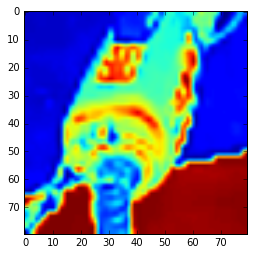

In [14]:

#print (Te_Y)

from ipywidgets import interact, interactive, fixed
from ipywidgets import widgets

def f(x):
    plt.imshow(Tr_X[x].reshape(img_rows,img_rows))
    # print (model.predict(Tr_X[x].reshape(1,1,img_rows,img_rows)) )
    print (model.predict_classes(Tr_X[x].reshape(1,1,img_rows,img_rows)) ,'--><--', np.argmax(Tr_Y[x]) )

interact(f,x = 5)
#for i in range(12):
#    f(i)

### Model Loading and Reuse

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)

# LOG

- nb_filters = 32,64,128....etc
- lr = 1e-2, 1e-3,1e-4

- model.add(Activation('tanh'))
- model.add(Activation('relu'))...etc
- remove dropout
- shrink the neurno size


In [89]:

from sklearn.cross_validation import train_test_split
# loopover distraction_dir and slinding_window


def TrainFilePath(folderList, constrain=None, **kargs ):
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg')
    for basePath in folderList :
        for (rootDir, dirNames, fileNames) in os.walk(basePath):
            for fileName in fileNames:
                if fileName.split('.')[-1] in constrain:
                    yield os.path.join(rootDir, fileName), rootDir
                    
def sliding_window(image, stepSize, winSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
                yield (x, y, image[y:y + winSize[1], x:x + winSize[0]])
                
                
def pos_extract(conf):
    # grab the set of ground-truth images and select a percentage of them for training
    trnPaths = list(paths.list_images(conf["pos_raw_ph"]))
    assert len(trnPaths)!=0
    #
    if not os.path.isdir(conf['pos_feat_ph']):
        os.makedirs(conf['pos_feat_ph'])

    # setup the progress bar
    widgets = ["Extracting: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
    for (i, imgPath) in enumerate(trnPaths):
        # img = imread(imgPath)
        # resize to the training resolution (wid,height)
        img = auto_resized(imread(imgPath, as_grey=True),conf['sliding_size'])
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        fd=hog(img, conf['orientations'], conf['pixels_per_cell'], 
                    conf['cells_per_block'], conf['visualize'], conf['normalize'])
        fd_name = os.path.split(imgPath)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(conf['pos_feat_ph'], fd_name)
        joblib.dump(fd, fd_path)
        pbar.update(i)
    pbar.finish()
    print ('[*] Finished Pos.')


def extract(conf):
    # grab the set of ground-truth images and select a percentage of them for training
    trnPaths = list(paths.list_images(conf["neg_raw_ph"]))
    assert len(trnPaths)!=0
    #
    if not os.path.isdir(conf['neg_feat_ph']):
        os.makedirs(conf['neg_feat_ph'])
    # setup the progress bar
    widgets = ["Extracting: ", progressbar.Percentage(), " ",
        progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
    for (i, imgPath) in enumerate(trnPaths):
        # img = imread(imgPath)
        # resize to the training resolution (wid,height)
        img = auto_resized(imread(imgPath, as_grey=True),conf['train_resolution'])
        #######################################################
        # if some pos_img in neg_img with stationary position #
        #######################################################
        if conf['special_cover'] is not None:
            print ('[*] Triggerd special_cover')
            startX,startY,endX,endY = conf['special_cover']
            cv2.rectangle(img, (startX-10,startY-10), (endX+10,endY+10), 0, -1) 
            #################################
            # -1 = filled, 0 = outline only #
            #################################
        fd_id=0 #just a index for recording feature_file
        for x,y,window in sliding_window(img, conf['step_size'],conf['sliding_size']):
            if window.shape != tuple(conf['sliding_size']):
                pass
            else :
                fd=hog(window, conf['orientations'], conf['pixels_per_cell'], 
                    conf['cells_per_block'], conf['visualize'], conf['normalize'])
                fd_name = os.path.split(imgPath)[1].split(".")[0] +str(fd_id)+ ".feat"
                fd_path = os.path.join(conf['neg_feat_ph'], fd_name)
                joblib.dump(fd, fd_path)
                fd_id+=1
        pbar.update(i)
    pbar.finish()
    print ('[*] Finished Neg.')
